<a href="https://colab.research.google.com/github/RodrigoAgronomia/workshop_esalq/blob/master/python/Segmentation_03_C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install livelossplot
%cd /content
!git clone --depth 1 https://github.com/RodrigoAgronomia/workshop_esalq.git
%cd /content/workshop_esalq
!git pull
%cd /content/workshop_esalq/python

In [2]:
# Importação das bibliotecas necessárias para fazer o código funcionar - Caso apresente algum erro instalar a respectiva biblioteca
import os
import cv2
import time
import json
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from livelossplot import PlotLosses

In [3]:
# Verifica se o CUDA está presente no respectivo computador. Caso sim atribui ao devide. Caso não atribui o cpu, apresentando uma mensagem ao usuário
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
#Criando a arquitetura do modelo em questão - Parâmetros definidos nesta classe:
#  im_channels - Número de canais da imagem de entrada
#  out_channels - Número de canais produzidos pela camada de convolução - Repare que o valor de out_channels da camada anterior deve ser o mesmo do parâmetro in_channels da convolução que se segue
#  kernel_size - Tamanho do kernel (filtro) da convolução em questão
#  stride - número de unidades que o filtro muda a cada vez.
#  padding - Preenchimento adicionado a ambos os lados da entrada
#  BatchNorm2d - Parâmetro para ajuste e dimensionamento das ativações. Melhora a estabilidade e desempenho de uma RNA
#  MaxPool2d - Reduz o tamanho espacial da saída, substituindo valores no kernel por uma função desses valores
#  ReLU - Função de ativação da RNA
# OBS. Link interessante - https://www.jessicayung.com/explaining-tensorflow-code-for-a-convolutional-neural-network/

class CNNModel(torch.nn.Module):
    def __init__(self, n_classes):
        super(CNNModel, self).__init__()
        
        # Convolution 0
        self.cnn0 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn0 = torch.nn.BatchNorm2d(32)
        self.relu0 = torch.nn.ReLU()
        
        # Convolution 1
        self.cnn1 = torch.nn.Conv2d(in_channels=32, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(20)
        self.relu1 = torch.nn.ReLU()
        
        # Convolution 2
        self.cnn2 = torch.nn.Conv2d(in_channels=20, out_channels=12, kernel_size=7, stride=1, padding=3)
        self.bn2 = torch.nn.BatchNorm2d(12)
        self.relu2 = torch.nn.ReLU()
        
        # Convolution 3
        self.cnn3 = torch.nn.Conv2d(in_channels=12, out_channels=8, kernel_size=9, stride=1, padding=4)
        self.bn3 = torch.nn.BatchNorm2d(8)
        self.relu3 = torch.nn.ReLU()
        
        self.pred = torch.nn.Conv2d(in_channels=8, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

        
    def forward(self, x):
        # Convolution 1
        out = self.relu0(self.bn0(self.cnn0(x)))
        out = self.relu1(self.bn1(self.cnn1(out)))
        out = self.relu2(self.bn2(self.cnn2(out)))
        out = self.relu3(self.bn3(self.cnn3(out)))
        out = self.pred(out) 
        return (out)

In [5]:
def prep_image(image):
    image = np.moveaxis(image, 2, 0)
    image = image.astype('float')
    image -= 128
    image /= 35
    return(image)
    
    
# Classe para preparo do dataset de treinamento e validação
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, im_dir, imList):
        data = []
        #Prepara as imagens no formato numpy para poder ser lida pelo modelo
        for idx in range(len(imList)):
            image_name = imList[idx]
            image = cv2.imread(os.path.join(im_dir, image_name))
            image = prep_image(image)

            label = cv2.imread(os.path.join(im_dir, image_name.replace('.png', '_msk.png')))
            label = np.digitize(label[:,:,0], [250, 255]).astype('uint8')

            image = torch.from_numpy(image)
            label = torch.from_numpy(label)
            data.append([image, label])
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image, label = self.data[idx]
        images = Variable(image).to(device, dtype=torch.float)
        label = Variable(label).to(device, dtype=torch.long)
        
        return (images, label) #Retorna a imagem com sua respectiva máscara

In [6]:
# Diretório das imagens
im_dir = '../data/class'

imgs = sorted(os.listdir(im_dir))
imgs = [i for i in imgs if not i.endswith('msk.png')]
imgs = np.array(imgs)
# Seleciona aleatoriamente as imagens de treinamento e validação
im_train = np.arange(len(imgs))
im_val = np.random.choice(im_train, 30, replace=False)
im_train = np.setdiff1d(im_train,im_val)


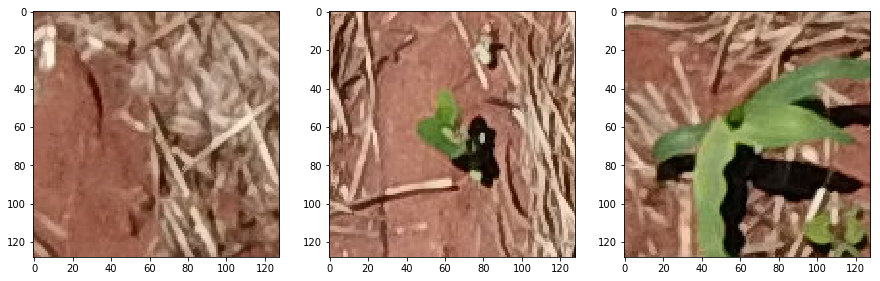

In [7]:
# Plota algumas das imagens dentro da pasta utilizada pelo modelo
plt.figure(figsize = (15,9))

im0 = cv2.imread(os.path.join(im_dir, imgs[50]))
im1 = cv2.imread(os.path.join(im_dir, imgs[150]))
im2 = cv2.imread(os.path.join(im_dir, imgs[250]))

ims = [im0, im1, im2]
for i in range(len(ims)):
        plt.figure(1)
        plt.subplot(1, 3, i+1)
        plt.imshow(ims[i][:,:,[2,1,0]])


In [8]:
train_dataset =  MyDataset(im_dir, imgs[im_train]) #Seleciona as respectivas imagens de treinamento
val_dataset =  MyDataset(im_dir, imgs[im_val]) #Seleciona as respectivas imagens de validação

In [9]:
# Batch_size (tamanho de lote) - número de exemplos de treinamento usados em uma iteração
# Carrega o dataset de treinamento
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=100,
                          shuffle=True,
                          num_workers=0
                         )

# Carrega o dataset de validação
val_loader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=10,
                          shuffle=False,
                          num_workers=0
                         )

In [10]:
n_classes = 3 # Número de classes utilizada no treinamento 
model = CNNModel(n_classes)
model = model.to(device)
liveloss = PlotLosses()

In [11]:
# Apresenta um resumo das informações carregadas até o momento
# Input_size(numero de classes, tamanho da imagem - Resolução)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 20, 128, 128]          16,020
       BatchNorm2d-5         [-1, 20, 128, 128]              40
              ReLU-6         [-1, 20, 128, 128]               0
            Conv2d-7         [-1, 12, 128, 128]          11,772
       BatchNorm2d-8         [-1, 12, 128, 128]              24
              ReLU-9         [-1, 12, 128, 128]               0
           Conv2d-10          [-1, 8, 128, 128]           7,784
      BatchNorm2d-11          [-1, 8, 128, 128]              16
             ReLU-12          [-1, 8, 128, 128]               0
           Conv2d-13          [-1, 3, 128, 128]              27
Total params: 36,643
Trainable params: 

In [79]:
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 5e-3 #Taxa de aprendizado
# torch.optim é um pacote que contém vários algoritmos de otimização dentro das RNAs
# OBS. Para mais detalhes - https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adam(model.parameters(), learning_rate, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)

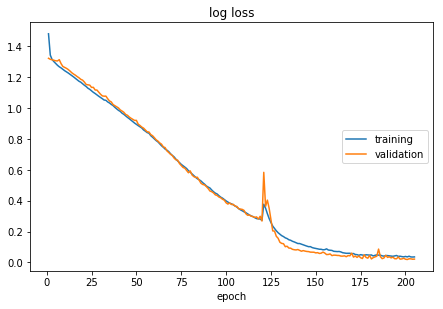

log loss:
training   (min:    0.035, max:    1.482, cur:    0.036)
validation (min:    0.019, max:    1.323, cur:    0.022)
[84] loss: 0.036 time:1.44


In [ ]:
min_loss = 1
num_epochs = 120 # Define o número de épocas para realizar o treinamento 
for epoch in range(num_epochs):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        outputs = model(images)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, labels)

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (images, labels) in enumerate(val_loader):
        with torch.no_grad():
          # Obtem o output
          outputs = model(images)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, labels)

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        model_file_name = '../data/models/model_seg.pth'
        torch.save(model.state_dict(), model_file_name)

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d] loss: %.3f time:%.2f' % (epoch, epoch_loss, time_taken))

In [61]:
# Cria um novo modelo
n_classes = 3
model = CNNModel(n_classes)
model = model.to(device)

# Carrega os pesos de um modelo salvo
model.load_state_dict(torch.load('../data/models/model_seg.pth', map_location=device))

#Apresenta uma mensagem caso esteja tudo certo com o modelo
print('Modelo OK')

Modelo OK


In [62]:
# Inicia o tempo para contagem
start_time = time.time()

# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
obs = []
preds = []
for i, (images, labels) in enumerate(val_loader):
    obs.append(labels.cpu().data.numpy())
    with torch.no_grad():
        pred = F.softmax(model(images), 1)
    preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs)
preds = np.concatenate(preds)

# Faz a diferença para calcular o tempo           
time_taken = time.time() - start_time
# Apresenta o valor do tempo
print('time:%.2f' % (time_taken))


time:0.07


In [64]:
image_name = '../data/class/IMG_2029.png'
image_orig = cv2.imread(image_name)
image = prep_image(image_orig)

image = torch.from_numpy(image[np.newaxis,:])
image = Variable(image).to(device, dtype=torch.float)
        
pred =  F.softmax(model(image), 1).cpu().data.numpy()[0]


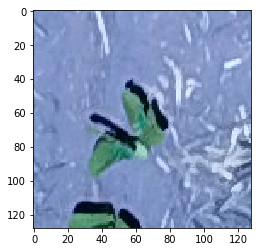

In [65]:
plt.imshow(image_orig)

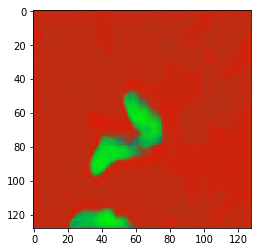

In [66]:
plt.imshow(np.moveaxis(pred, 0, 2))

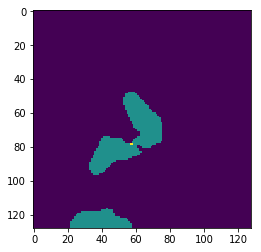

In [67]:
plt.imshow(pred.argmax(0))

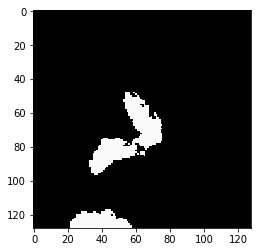

In [73]:
label = cv2.imread(image_name.replace('.png', '_msk.png'))
plt.imshow(label)

In [74]:
image_name = '../data/class/IMG_3029.png'
image_orig = cv2.imread(image_name)
image = prep_image(image_orig)

image = torch.from_numpy(image[np.newaxis,:])
image = Variable(image).to(device, dtype=torch.float)
        
pred =  F.softmax(model(image), 1).cpu().data.numpy()[0]


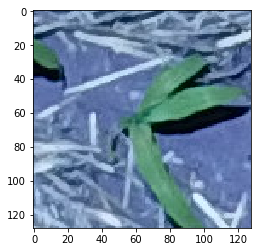

In [75]:
plt.imshow(image_orig)

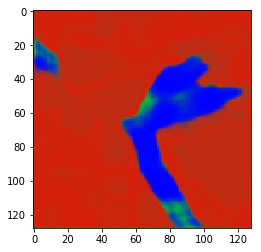

In [76]:
plt.imshow(np.moveaxis(pred, 0, 2))

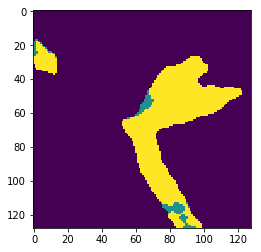

In [77]:
plt.imshow(pred.argmax(0))

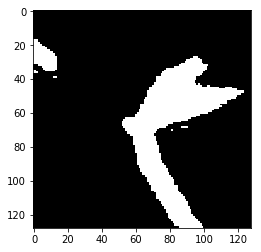

In [78]:
label = cv2.imread(image_name.replace('.png', '_msk.png'))
plt.imshow(label)